In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Usual Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
features_df = pd.read_csv('/content/drive/MyDrive/music genre classification/Data/3sec_with_3_augmented_features.csv')
features_df

,filename,label,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc11_var,mfcc12_var,mfcc13_var,mfcc14_var,mfcc15_var,mfcc16_var,mfcc17_var,mfcc18_var,mfcc19_var,mfcc20_var
0,blues.00001.0.wav,blues,0.401777,0.090297,0.092470,0.003852,1280.783901,4.094138e+05,1921.746662,197987.429167,...,63.897583,43.533714,46.494700,44.821810,29.407215,39.717197,21.996435,19.852303,21.263311,21.941433
1,blues.00001.0.0.wav,blues,0.422309,0.096552,0.069239,0.001909,2762.251380,1.000738e+06,3090.408864,181227.327175,...,45.978400,18.679058,19.523615,20.024220,30.155720,21.372524,14.625088,14.956442,13.284389,19.998985
2,blues.00001.0.1.wav,blues,0.443314,0.096260,0.061294,0.001699,2217.885010,1.235275e+06,2742.151089,224920.847167,...,46.389280,24.738720,36.440823,23.869951,24.637384,25.521030,19.240702,20.864480,16.433887,21.780699
3,blues.00001.0.2.wav,blues,0.459021,0.088743,0.048640,0.001081,2808.021133,1.098000e+06,3214.574198,133799.389191,...,23.287700,18.645708,21.926825,17.859934,22.465862,18.845125,13.815695,14.730042,11.549602,11.658147
4,blues.00001.1.wav,blues,0.346199,0.091231,0.093970,0.001479,1517.462371,2.166230e+05,2097.839635,116583.738656,...,91.249260,84.488400,103.343285,49.605064,54.982300,59.656414,57.762740,27.554667,40.539470,33.801933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39959,rock.00098.8.2.wav,rock,0.342707,0.119389,0.007889,0.000069,4071.370983,8.218572e+05,3419.833217,61327.073120,...,13.241874,14.204902,21.207191,23.253115,20.386044,18.232553,19.360079,17.032099,14.748346,13.520498
39960,rock.00098.9.wav,rock,0.403830,0.088468,0.073046,0.000315,1183.288898,1.711232e+05,1848.019263,130149.034935,...,22.425350,20.251904,37.614643,17.496586,25.016434,37.478672,23.452723,23.316307,13.517374,14.046360
39961,rock.00098.9.0.wav,rock,0.385792,0.089155,0.050258,0.000111,1798.658101,1.019776e+05,2671.401975,46778.395896,...,18.242071,51.796806,30.613808,23.915588,24.737034,20.791864,32.425530,9.460902,12.321484,26.981295
39962,rock.00098.9.1.wav,rock,0.474697,0.095554,0.050309,0.000404,3793.755327,6.132599e+05,3464.448296,18848.577054,...,12.825383,14.016889,18.380644,14.189344,18.164795,18.141523,11.956756,20.779938,15.038365,15.865129


**split the features data into train, test and validation such that only train data contains augmented segment data, while validation and test contains only original audio segment data**

In [ ]:
# Dictionaries to store data
original_features = {}  # Stores only original features
augmented_features = defaultdict(list)  # Stores augmented samples
filename_dict = defaultdict(list)  # Track filenames

# Process features
for index, row in features_df.iterrows():
    filename = row['filename']
    genre = row['label']
    features = row.drop(['filename', 'label']).values.astype(np.float32)

    # Extract components from filename
    base_name = filename[:-4]  # Remove '.wav'
    parts = base_name.split('.')

    if len(parts) == 3:
        # Original sample (e.g., 'rock.00001.0.wav')
        genre, sample_id, part_id = parts
        key = f"{genre}.{sample_id}.{part_id}"  # Unique key for original sample
        original_features[key] = (features, genre)
        filename_dict[key].append(filename)

    elif len(parts) == 4:
        # Augmented sample (e.g., 'rock.00001.0.0.wav')
        genre, sample_id, part_id, aug_id = parts
        key = f"{genre}.{sample_id}.{part_id}"  # Link to corresponding original
        augmented_features[key].append((features, genre))
        filename_dict[key].append(filename)

# Sort original_features by keys for consistent splitting
sorted_original_features = dict(sorted(original_features.items()))

# Get the list of original feature keys (grouped by part-level) - now sorted
original_keys = list(sorted_original_features.keys())

# Ensure test/val split includes ONLY original features
train_keys, temp_keys = train_test_split(
    original_keys, test_size=0.35, random_state=42, stratify=[key.split('.')[0] for key in original_keys]
)
val_keys, test_keys = train_test_split(
    temp_keys, test_size=0.5, random_state=42, stratify=[key.split('.')[0] for key in temp_keys]
)

# Initialize train, validation, and test sets
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []
test_filenames = []  # Store test filenames for verification

# Validation & Test Sets: Only Add Original Features
for key in val_keys:
    features, label = sorted_original_features[key]
    X_val.append(features)
    y_val.append(label)
    test_filenames.append(f"{key}.wav")  # Directly construct original filename

for key in test_keys:
    features, label = sorted_original_features[key]
    X_test.append(features)
    y_test.append(label)
    test_filenames.append(f"{key}.wav")  # Directly construct original filename

# Train Set: Add Both Original & Augmented Samples
for key in train_keys:
    features, label = sorted_original_features[key]
    X_train.append(features)
    y_train.append(label)

    # Add Corresponding Augmented Samples to Training Set
    if key in augmented_features:
        for aug_features, aug_label in augmented_features[key]:
            X_train.append(aug_features)
            y_train.append(aug_label)

# Convert to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)



# Print sample counts
print(f"\nTrain samples: {len(y_train)}, Validation samples: {len(y_val)}, Test samples: {len(y_test)}\n")

# Print label distribution in a readable format
def print_label_distribution(dataset_name, labels):
    label_counts = Counter(labels)
    print(f"Label distribution in {dataset_name} Data:")
    for label, count in sorted(label_counts.items()):
        print(f"{label}: {count} samples")
    print()  # Blank line for readability

print_label_distribution("Train", y_train)
print_label_distribution("Validation", y_val)
print_label_distribution("Test", y_test)

# Print test filenames (only original features)
print("Filenames in Test Data (should be only original features):")
print("\n".join(sorted(test_filenames)[:10]))  # Print first 10 filenames for readability


# Save before transformations
np.save('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/X_train_feature_raw.npy', X_train)
np.save('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/X_val_feature_raw.npy', X_val)
np.save('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/X_test_feature_raw.npy', X_test)
np.save('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/y_train_feature_raw.npy', np.array(y_train, dtype=object))
np.save('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/y_val_feature_raw.npy', np.array(y_val, dtype=object))
np.save('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/y_test_feature_raw.npy', np.array(y_test, dtype=object))



Train samples: 25976, Validation samples: 1748, Test samples: 1749

Label distribution in Train Data:
blues: 2600 samples
classical: 2596 samples
country: 2592 samples
disco: 2596 samples
hiphop: 2596 samples
jazz: 2600 samples
metal: 2600 samples
pop: 2600 samples
reggae: 2600 samples
rock: 2596 samples

Label distribution in Validation Data:
blues: 175 samples
classical: 174 samples
country: 175 samples
disco: 175 samples
hiphop: 174 samples
jazz: 175 samples
metal: 175 samples
pop: 175 samples
reggae: 175 samples
rock: 175 samples

Label distribution in Test Data:
blues: 175 samples
classical: 175 samples
country: 174 samples
disco: 175 samples
hiphop: 175 samples
jazz: 175 samples
metal: 175 samples
pop: 175 samples
reggae: 175 samples
rock: 175 samples

Filenames in Test Data (should be only original features):
blues.00000.1.wav
blues.00000.4.wav
blues.00000.8.wav
blues.00001.3.wav
blues.00001.4.wav
blues.00002.0.wav
blues.00002.1.wav
blues.00002.7.wav
blues.00003.2.wav
blues.000

In [ ]:
# Option to load data
LOAD_FROM_FILES = True  # Set to True to load saved data instead of recomputing

if LOAD_FROM_FILES:
    X_train = np.load('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/X_train_feature_raw.npy')
    X_val = np.load('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/X_val_feature_raw.npy')
    X_test = np.load('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/X_test_feature_raw.npy')
    y_train = np.load('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/y_train_feature_raw.npy', allow_pickle=True)
    y_val = np.load('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/y_val_feature_raw.npy', allow_pickle=True)
    y_test = np.load('/content/drive/MyDrive/music genre classification/Data/numpy_array_data/y_test_feature_raw.npy', allow_pickle=True)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
joblib.dump(scaler, 'scaler.pkl')

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
joblib.dump(label_encoder, 'label_encoder.pkl')

# One-hot encoding
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes=num_classes)
y_val = to_categorical(y_val_encoded, num_classes=num_classes)
y_test = to_categorical(y_test_encoded, num_classes=num_classes)


In [ ]:
# print shape of data
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (25976, 57)
X_val shape: (1748, 57)
X_test shape: (1749, 57)


In [ ]:
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def model_evaluation_report(model):

  # Evaluate the model on the test data
  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis=1)

  # Inverse transform encoded labels to original labels
  y_test_original = label_encoder.inverse_transform(y_test.argmax(axis=1))
  y_pred_original = label_encoder.inverse_transform(y_pred_classes)

  # Print classification report
  print(classification_report(y_test_original, y_pred_original))

  # Plot the confusion matrix
  conf_matrix = confusion_matrix(y_test_original, y_pred_original)
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, cmap='Blues',  annot=True)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=90)
  plt.yticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_)
  plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# model 1
# Build the deep learning model
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.6))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Define a ModelCheckpoint callback to save the entire model (including architecture and weights)
model_checkpoint = ModelCheckpoint('ann_feature_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True, verbose=1  # Stop if val_loss doesn't improve for 5 epochs
)


# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=150, batch_size=128, validation_data=(X_val, y_val), callbacks=[model_checkpoint, early_stopping])



Epoch 1/150
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1614 - loss: 2.2477
Epoch 1: val_accuracy improved from -inf to 0.46739, saving model to ann_feature_10sec_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.1618 - loss: 2.2467 - val_accuracy: 0.4674 - val_loss: 1.4387
Epoch 2/150
200/203 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3945 - loss: 1.6634
Epoch 2: val_accuracy improved from 0.46739 to 0.56465, saving model to ann_feature_10sec_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3949 - loss: 1.6624 - val_accuracy: 0.5646 - val_loss: 1.2374
Epoch 3/150
201/203 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4638 - loss: 1.4997
Epoch 3: val_accuracy improved from 0.56465 to 0.63787, saving model to ann_feature_10sec_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4640 - loss: 1.4993 - val_accuracy: 0.6379 - val_loss: 1.1054
Epoch 4/150
201/203 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5119 - loss

In [ ]:
# Load the best model
from tensorflow.keras.models import load_model
model = load_model('ann_feature_model.keras')

# Evaluate the model's accuracy on train and test sets
train_acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1))
validate_acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(model.predict(X_val), axis=1))
test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))

# Print the accuracy scores
print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {validate_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

812/812 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train Accuracy: 95.90%
Validation Accuracy: 91.93%
Test Accuracy: 91.02%


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

       blues       0.94      0.94      0.94       175
   classical       0.93      0.93      0.93       175
     country       0.85      0.90      0.87       174
       disco       0.89      0.90      0.90       175
      hiphop       0.96      0.90      0.93       175
        jazz       0.88      0.91      0.90       175
       metal       0.94      0.96      0.95       175
         pop       0.95      0.88      0.91       175
      reggae       0.90      0.95      0.93       175
        rock       0.86      0.83      0.85       175

    accuracy                           0.91      1749
   macro avg       0.91      0.91      0.91      1749
weighted avg       0.91      0.91      0.91      1749



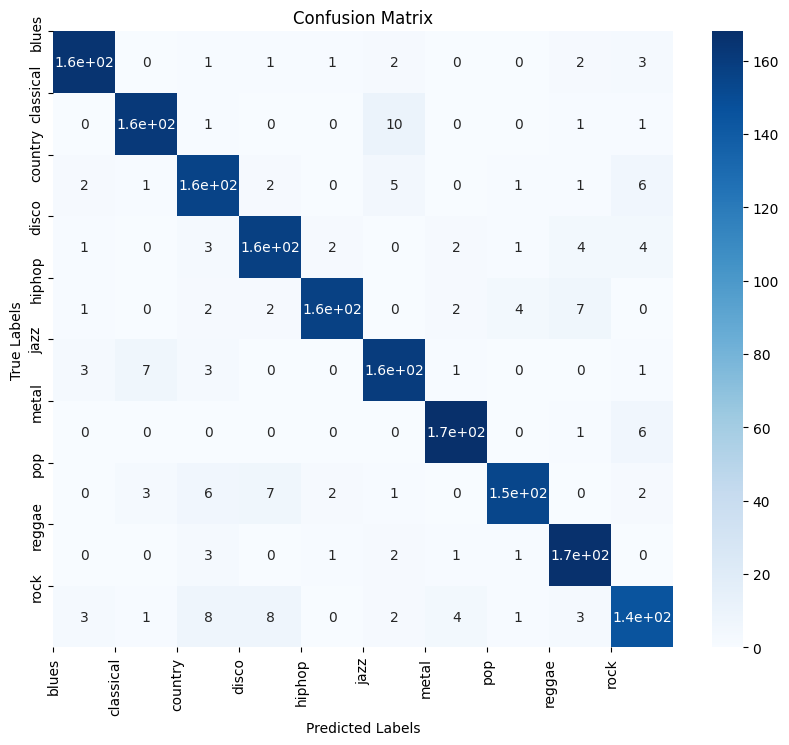

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('ann_feature_10sec_model.keras')
model_evaluation_report(model)

## cnn model

In [ ]:
# Build the CNN model
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.5))

model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Define a ModelCheckpoint callback to save the entire model (including architecture and weights)
model_checkpoint = ModelCheckpoint('cnn_feature_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True, verbose=1  # Stop if val_loss doesn't improve for 5 epochs
)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_val, y_val), callbacks=[model_checkpoint, early_stopping])



Epoch 1/250


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1130 - loss: 2.3133
Epoch 1: val_accuracy improved from -inf to 0.18021, saving model to cnn_feature_10sec_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.1131 - loss: 2.3131 - val_accuracy: 0.1802 - val_loss: 2.1581
Epoch 2/250
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2011 - loss: 2.0800
Epoch 2: val_accuracy improved from 0.18021 to 0.37014, saving model to cnn_feature_10sec_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.2012 - loss: 2.0796 - val_accuracy: 0.3701 - val_loss: 1.7429
Epoch 3/250
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3211 - loss: 1.8370
Epoch 3: val_accuracy improved from 0.37014 to 0.49314, saving model to cnn_feature_10sec_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.3212 - loss: 1.8368 - val_accuracy: 0.4931 - val_loss: 1.4938
Epoch 4/250
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3882 - loss: 1.6931


In [ ]:
# Load the best model
from tensorflow.keras.models import load_model
model = load_model('cnn_feature_model.keras')

# Evaluate the model's accuracy on train and test sets
train_acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1))
validate_acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(model.predict(X_val), axis=1))
test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))

# Print the accuracy scores
print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {validate_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

812/812 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Train Accuracy: 96.33%
Validation Accuracy: 89.30%
Test Accuracy: 89.71%


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

       blues       0.91      0.93      0.92       175
   classical       0.95      0.98      0.97       175
     country       0.83      0.85      0.84       174
       disco       0.88      0.88      0.88       175
      hiphop       0.89      0.92      0.90       175
        jazz       0.91      0.89      0.90       175
       metal       0.91      0.93      0.92       175
         pop       0.93      0.89      0.91       175
      reggae       0.90      0.92      0.91       175
        rock       0.86      0.78      0.82       175

    accuracy                           0.90      1749
   macro avg       0.90      0.90      0.90      1749
weighted avg       0.90      0.90      0.90      1749



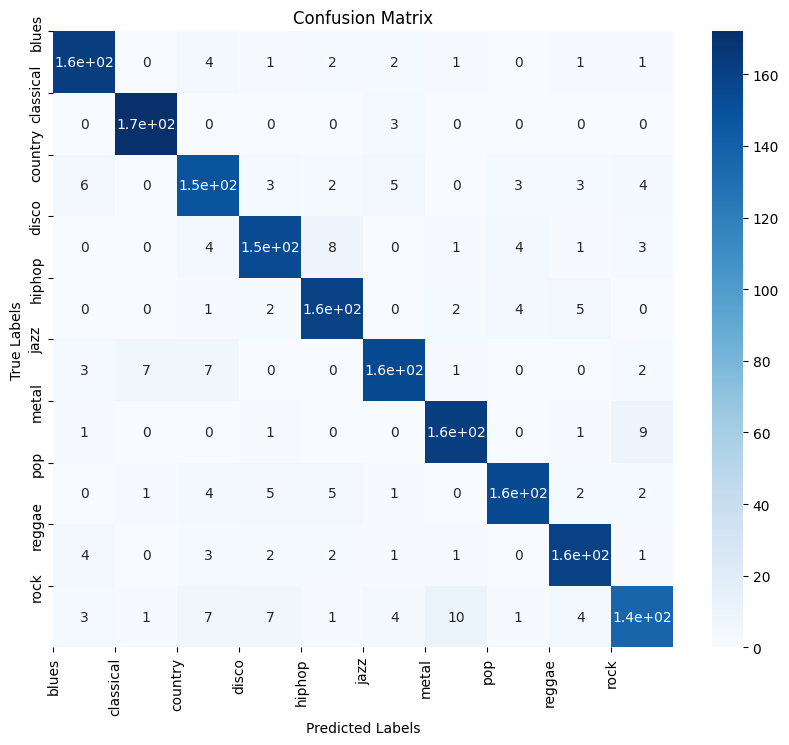

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('cnn_feature_model.keras')
model_evaluation_report(model)